# Models Creation

In [1]:
import cv2
import numpy as np
import os
import sys
import pandas as pd
from sklearn.model_selection import train_test_split

In [2]:
import tensorflow as tf

2025-04-18 21:31:10.307948: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


In [3]:
# Listar GPUs disponibles
gpus = tf.config.experimental.list_physical_devices('GPU')

if gpus:
    try:
        # Asegúrate de que la GPU 1 existe
        print("GPUs disponibles:")
        for i, gpu in enumerate(gpus):
            print(f"GPU {i}: {gpu}")

        # Limitar visibilidad a solo la GPU 1
        tf.config.experimental.set_visible_devices(gpus[1], 'GPU')

        # Establecer límite de memoria a 40 GB
        tf.config.experimental.set_virtual_device_configuration(
            gpus[1],
            [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=40960)]
        )

        print("Configuración de GPU establecida correctamente.")
    except RuntimeError as e:
        print("Error al configurar la GPU:", e)
else:
    print("No se encontraron GPUs disponibles.")

GPUs disponibles:
GPU 0: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
GPU 1: PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')
Configuración de GPU establecida correctamente.


2025-04-18 21:31:11.589068: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2025-04-18 21:31:11.633943: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:0a:00.0 name: NVIDIA A100 80GB PCIe computeCapability: 8.0
coreClock: 1.41GHz coreCount: 108 deviceMemorySize: 79.25GiB deviceMemoryBandwidth: 1.76TiB/s
2025-04-18 21:31:11.634963: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 1 with properties: 
pciBusID: 0000:ae:00.0 name: NVIDIA A100 80GB PCIe computeCapability: 8.0
coreClock: 1.41GHz coreCount: 108 deviceMemorySize: 79.25GiB deviceMemoryBandwidth: 1.76TiB/s
2025-04-18 21:31:11.634990: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2025-04-18 21:31:11.643528: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.

In [4]:
os.environ['TF_DETERMINISTIC_OPS'] = '1'

In [5]:
# Poner todas las seed en 42
import random
seed = 42
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

In [6]:
# Agrega el path al directorio raíz del proyecto
sys.path.append(os.path.abspath(".."))
from models.i3d import InceptionI3d

In [7]:
train_df = pd.read_csv("../data/ml/train.csv")
valid_df = pd.read_csv("../data/ml/valid.csv")
test_df = pd.read_csv("../data/ml/test.csv")


In [8]:
"""data = pd.read_csv("../data/ml/test.csv")
# Dividir el dataset en train (80%), valid (10%), test (10%)
train_df, test_valid_df = train_test_split(data, test_size=0.2, random_state=42, stratify=data['is_crime'])
valid_df, test_df = train_test_split(test_valid_df, test_size=0.5, random_state=42)"""

'data = pd.read_csv("../data/ml/test.csv")\n# Dividir el dataset en train (80%), valid (10%), test (10%)\ntrain_df, test_valid_df = train_test_split(data, test_size=0.2, random_state=42, stratify=data[\'is_crime\'])\nvalid_df, test_df = train_test_split(test_valid_df, test_size=0.5, random_state=42)'

## Data Loader

In [9]:
from tensorflow.keras.utils import to_categorical
class VideoDataModule:
    def __init__(self, train_df, val_df, test_df, batch_size=8, frame_size=(224, 224), num_frames=32):
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df
        self.batch_size = batch_size
        self.frame_size = frame_size
        self.num_frames = num_frames
        tf.random.set_seed(42)  # Establecer la semilla

    def _load_video_frames(self, video_path, start_frame, end_frame, training=False):
        cap = cv2.VideoCapture(video_path)
        
        if not cap.isOpened():
            print(f"Error: No se pudo abrir el video {video_path}")
            return None
        
        frames = []
        total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        
        start_frame = int(start_frame) if not np.isnan(start_frame) else 0
        end_frame = int(end_frame) if not np.isnan(end_frame) else total_frames
        
        # Chequear si el video tiene suficientes frames
        if end_frame - start_frame < self.num_frames:
            print(f"Advertencia: {video_path} tiene menos frames que los requeridos. Usando todo el video.")
        
        # Temporal offset aleatorio
        if training:
            # Ajustar máximo punto de inicio si hay menos frames disponibles que num_frames
            max_start = max(start_frame, end_frame - self.num_frames * max(1, (end_frame - start_frame) // self.num_frames))
            clip_start = np.random.randint(start_frame, max_start + 1)
        else:
            clip_start = start_frame
        
        cap.set(cv2.CAP_PROP_POS_FRAMES, clip_start)

        step = max(1, (end_frame - start_frame) // self.num_frames)

        for _ in range(self.num_frames):
            ret, frame = cap.read()
            if not ret:
                break
            
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            frame = tf.convert_to_tensor(frame, dtype=tf.float32)

            if training:
                # Padding + random crop
                frame = tf.image.resize_with_crop_or_pad(frame, 240, 240)
                frame = tf.image.random_crop(frame, size=[*self.frame_size, 3])
                
                # Augmentaciones base
                frame = tf.image.random_flip_left_right(frame, seed=42)
                frame = tf.image.random_brightness(frame, max_delta=0.2, seed=42)
                frame = tf.image.random_contrast(frame, lower=0.8, upper=1.2, seed=42)
                frame = tf.image.random_hue(frame, max_delta=0.05, seed=42)

                # Posibilidad de añadir ruido o blur
                if np.random.rand() < 0.2:
                    noise = tf.random.normal(shape=tf.shape(frame), mean=0.0, stddev=5.0)
                    frame = tf.clip_by_value(frame + noise, 0.0, 255.0)

                if np.random.rand() < 0.2:
                    # Blur usando OpenCV
                    frame = tf.cast(frame, tf.uint8).numpy()
                    frame = cv2.GaussianBlur(frame, (5, 5), 0)
                    frame = tf.convert_to_tensor(frame, dtype=tf.float32)

            else:
                # Normal resize para validación/test
                frame = tf.image.resize(frame, self.frame_size)

            # Normalización final
            frame = frame / 255.0
            frames.append(frame.numpy())

            for _ in range(step - 1):  # Saltar frames para ajustarse al total
                cap.read()

        cap.release()

        # Si faltan frames, completamos con ceros
        while len(frames) < self.num_frames:
            frames.append(np.zeros((*self.frame_size, 3)))

        return np.array(frames, dtype=np.float32)


    def _dataframe_to_tf_dataset(self, df, shuffle=True, training=False):
        file_paths = df["Path"].values
        start_frames = df["PCB"].values
        end_frames = df["End_Frame"].values
        labels = df["is_crime"].values

        def generator():
            one_hot_labels = to_categorical(labels, num_classes=2)  # Convertimos una sola vez fuera del bucle
            for i in range(len(file_paths)):
                video_tensor = self._load_video_frames(file_paths[i], start_frames[i], end_frames[i], training)
                yield video_tensor, one_hot_labels[i]

        dataset = tf.data.Dataset.from_generator(
            generator,
            output_signature=(
                tf.TensorSpec(shape=(self.num_frames, *self.frame_size, 3), dtype=tf.float32),
                tf.TensorSpec(shape=(2,), dtype=tf.float32),
            ),
        )

        if shuffle:
            dataset = dataset.shuffle(
                buffer_size=min(max(1000, len(df)//10), len(df)),  
                seed=42,  
                reshuffle_each_iteration=True  
            )

        dataset = dataset.batch(self.batch_size).prefetch(tf.data.AUTOTUNE)
        return dataset

    def train_dataset(self):
        return self._dataframe_to_tf_dataset(self.train_df, shuffle=True, training=True)

    def val_dataset(self):
        return self._dataframe_to_tf_dataset(self.val_df, shuffle=False, training=False)

    def test_dataset(self):
        return self._dataframe_to_tf_dataset(self.test_df, shuffle=False, training=False)

## Train with checkpoints

In [10]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler
def train_with_checkpoints(model, train_dataset, val_dataset, epochs, checkpoint_dir, one_cycle_scheduler):
    os.makedirs(checkpoint_dir, exist_ok=True)

    last_epoch_file = os.path.join(checkpoint_dir, "last_epoch.npy")
    history_file = os.path.join(checkpoint_dir, "history.npy")

    # Callback para guardar TODAS las épocas
    full_history_callback = ModelCheckpoint(
        filepath=os.path.join(checkpoint_dir, "epoch_{epoch:02d}"),
        save_freq='epoch',
        save_weights_only=True
    )

    # Callback para guardar solo el MEJOR modelo
    best_model_callback = ModelCheckpoint(
        filepath=os.path.join(checkpoint_dir, "best_model"),
        monitor="val_loss",
        mode="min",
        save_best_only=True,
        save_weights_only=True
    )

    # Intentar cargar la última época guardada
    if os.path.exists(last_epoch_file):
        initial_epoch = int(np.load(last_epoch_file))
        model.load_weights(os.path.join(checkpoint_dir, "best_model"))
        print(f"Resuming training from epoch {initial_epoch}")
    else:
        initial_epoch = 0
        print("Starting training from scratch.")

    # Callback para detener el entrenamiento si no hay mejora
    early_stop_callback = EarlyStopping(
        monitor="val_loss", 
        patience=30, 
        mode="min", 
        restore_best_weights=True
    )

    # Callback para guardar la época actual
    class EpochSaver(tf.keras.callbacks.Callback):
        def on_epoch_end(self, epoch, logs=None):
            np.save(last_epoch_file, epoch + 1)

    # Callback para guardar historial después de cada época
    class HistorySaver(tf.keras.callbacks.Callback):
        def on_epoch_end(self, epoch, logs=None):
            if logs is not None:
                history_full['loss'].append(logs.get('loss', None))
                history_full['val_loss'].append(logs.get('val_loss', None))
                np.save(history_file, history_full)

    epoch_saver_callback = EpochSaver()
    history_saver_callback = HistorySaver()
    lr_scheduler_callback = LearningRateScheduler(one_cycle_scheduler)
    # Cargar historial previo si existe
    if os.path.exists(history_file):
        history_full = np.load(history_file, allow_pickle=True).item()
    else:
        history_full = {'loss': [], 'val_loss': []}

    # Verificar si el entrenamiento ya ha terminado
    if initial_epoch >= epochs:
        print("Training already completed. No new epochs to run.")
        return None, history_full

    # Iniciar entrenamiento
    history = model.fit(
        train_dataset,
        validation_data=val_dataset,
        epochs=epochs,
        initial_epoch=initial_epoch,
        callbacks=[
            early_stop_callback, 
            best_model_callback, 
            full_history_callback, 
            epoch_saver_callback, 
            history_saver_callback, 
            lr_scheduler_callback
        ],
        verbose=1
    )

    return history, history_full

## Learning rate Finder

In [11]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from typing import Optional, Tuple

class LRFinder(tf.keras.callbacks.Callback):
    def __init__(self, min_lr: float = 1e-6, max_lr: float = 1, steps: int = 100, smoothing: float = 0.05):
        super().__init__()
        self.min_lr = min_lr
        self.max_lr = max_lr
        self.total_steps = steps
        self.smoothing = smoothing  # Para suavizado exponencial de la pérdida
        self.lrs = []
        self.losses = []
        self.smoothed_losses = []
        self.best_loss = float("inf")
        self._step = 0
        self._avg_loss = 0

    def on_train_begin(self, logs=None):
        self._step = 0
        self.lr_mult = (self.max_lr / self.min_lr) ** (1 / self.total_steps)
        tf.keras.backend.set_value(self.model.optimizer.lr, self.min_lr)
        self.lrs.clear()
        self.losses.clear()
        self.smoothed_losses.clear()
        self.best_loss = float("inf")
        self._avg_loss = 0

    def on_batch_end(self, batch, logs=None):
        self._step += 1
        lr = tf.keras.backend.get_value(self.model.optimizer.lr)
        loss = logs["loss"]
        
        # Suavizado exponencial de la pérdida
        if self._step == 1:
            self._avg_loss = loss
        else:
            self._avg_loss = self.smoothing * loss + (1 - self.smoothing) * self._avg_loss
        
        self.lrs.append(lr)
        self.losses.append(loss)
        self.smoothed_losses.append(self._avg_loss)

        # Actualizar mejor pérdida
        if self._avg_loss < self.best_loss:
            self.best_loss = self._avg_loss

        # Condición de parada
        if self._step > self.total_steps or tf.math.is_nan(loss): # or loss > self.best_loss * 10:
            self.model.stop_training = True
            return

        # Actualizar LR para el siguiente batch
        lr *= self.lr_mult
        tf.keras.backend.set_value(self.model.optimizer.lr, lr)

    def plot_loss(self, skip_start: int = 10, skip_end: int = 5, log_scale: bool = True):
        """Grafica la pérdida vs learning rate."""
        lrs = self.lrs[skip_start:-skip_end or None]
        losses = self.smoothed_losses[skip_start:-skip_end or None]
        
        fig, ax = plt.subplots(figsize=(10, 6))
        ax.plot(lrs, losses)
        
        if log_scale:
            ax.set_xscale('log')
        
        ax.set_xlabel('Learning Rate')
        ax.set_ylabel('Loss')
        ax.set_title('Learning Rate Finder')
        ax.grid(True, which='both', linestyle='--', alpha=0.6)
        return fig, ax

## I3D Model

In [12]:
epochs = 2  # Número de épocas para el entrenamiento
num_classes = 2 # Número de clases

In [35]:
# Clase adaptadora para usar InceptionI3D como modelo de Keras
class KerasI3D(tf.keras.Model):
    def __init__(self, num_classes, endpoint = "Predictions"):
        super(KerasI3D, self).__init__()
        self.i3d = InceptionI3d(num_classes=num_classes, is_training=True, final_endpoint=endpoint)
        
    def call(self, inputs, training=False):
        logits, _ = self.i3d(inputs)  # El modelo I3D devuelve logits y endpoints
        return logits

### Modelo

In [31]:
initial_learning_rate = 1e-7

In [36]:
from tensorflow.keras.metrics import AUC

# Crear el DataModule
data_module = VideoDataModule(train_df, valid_df, test_df, batch_size=8)
# Obtener los datasets
train_dataset = data_module.train_dataset()
val_dataset = data_module.val_dataset()
test_dataset = data_module.test_dataset()

model_1 = KerasI3D(num_classes=num_classes)
optimizer = tf.keras.optimizers.Adam(
    learning_rate=initial_learning_rate,
)
loss_fn = tf.keras.losses.BinaryCrossentropy(from_logits=False)
model_1.compile(optimizer=optimizer, loss=loss_fn, metrics=["accuracy", AUC(name="auc")])

In [16]:
# Instanciar el LRFinder
lr_finder = LRFinder(min_lr=1e-11, max_lr=1e-2, steps=65, smoothing=0.5)
# Ejecutar el LRFinder sobre un subconjunto del dataset (mejor si es un subconjunto pequeño)
model_1.fit(
    train_dataset.take(200),  # puedes ajustar este valor según el tamaño de tus batches
    epochs=1,
    callbacks=[lr_finder]
)


2025-04-16 22:39:16.955775: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.
2025-04-16 22:39:19.428006: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2025-04-16 22:39:19.454274: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 2100000000 Hz
2025-04-16 22:39:36.356220: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 32 of 516
2025-04-16 22:39:46.249888: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 68 of 516


Advertencia: ../data/train/Shoplifting042_x264.mp4 tiene menos frames que los requeridos. Usando todo el video.


2025-04-16 22:39:56.512757: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 101 of 516
2025-04-16 22:40:06.670791: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 134 of 516
2025-04-16 22:40:16.609122: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 159 of 516
2025-04-16 22:40:26.347762: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 189 of 516
2025-04-16 22:40:36.420174: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 218 of 516
2025-04-16 22:40:46.668358: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 246 of 516
2025-04-16 22:40:56.539801: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer 

      6/Unknown - 192s 316ms/step - loss: 0.6917 - accuracy: 0.5000 - auc: 0.5612WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.1424s vs `on_train_batch_end` time: 0.1516s). Check your callbacks.
65/65 [==============================] - 213s 339ms/step - loss: 0.7571 - accuracy: 0.5581 - auc: 0.5848


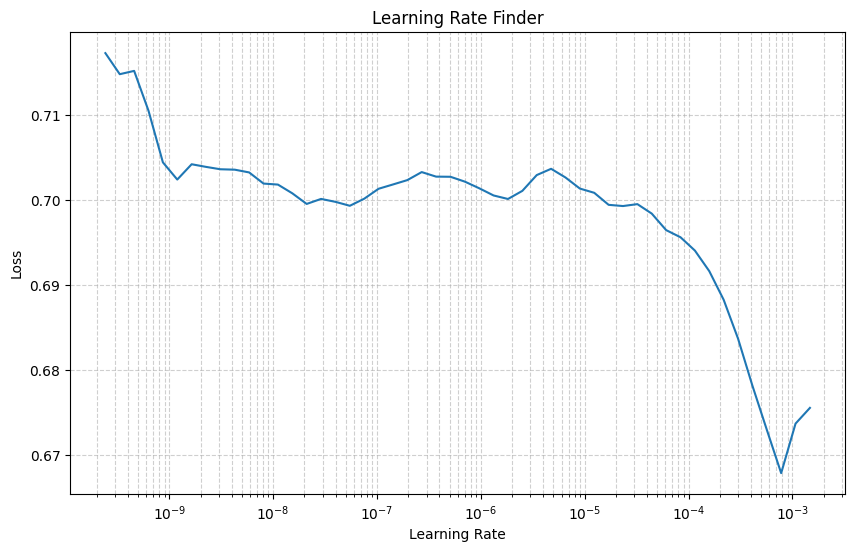

In [17]:
# Visualización
fig, ax = lr_finder.plot_loss()
plt.show()

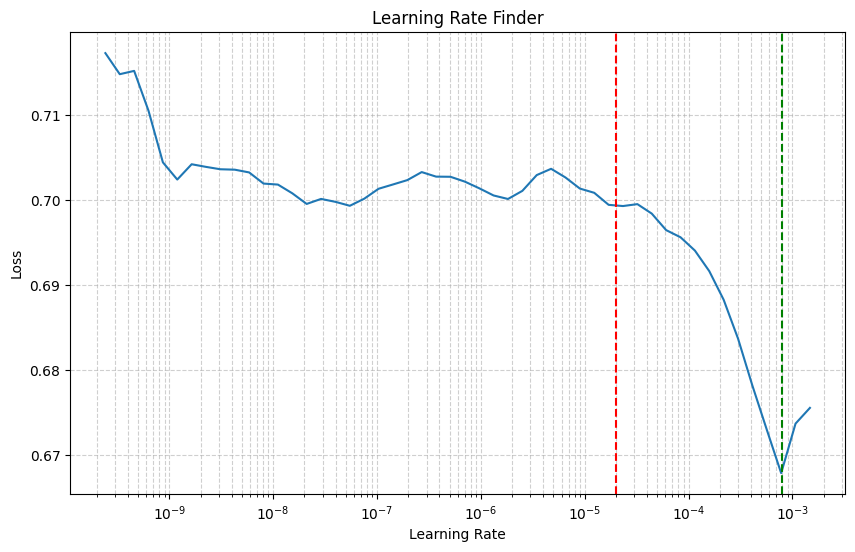

In [24]:
# Visualización
min_lr = 2e-5
max_lr = 8e-4
fig, ax = lr_finder.plot_loss()
ax.axvline(min_lr, color='r', linestyle='--', label='min_lr')
ax.axvline(max_lr, color='g', linestyle='--', label='max_lr')
plt.show()

### One Cycle Policy

In [19]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler

In [20]:
def one_cycle_scheduler(epoch, lr):
    total_epochs = epochs
    warmup_epochs = total_epochs // 4

    if epoch < warmup_epochs:  # Warmup
        return initial_learning_rate + (max_lr - initial_learning_rate) * (epoch / warmup_epochs)
    
    elif epoch < total_epochs - 5:  # Cosine annealing phase
        return min_lr + (max_lr - min_lr) * 0.5 * (1 + np.cos(np.pi * (epoch - warmup_epochs) / (total_epochs - warmup_epochs - 5)))

    else:  # Final annealing phase
        return min_lr

### Training

In [21]:
history, history_full = train_with_checkpoints(
    model_1,
    train_dataset,
    val_dataset,
    epochs=100,
    checkpoint_dir="checkpoints/i3d_model_1",
    one_cycle_scheduler=one_cycle_scheduler
)

Starting training from scratch.
Epoch 1/100


2025-04-16 22:42:54.671942: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 33 of 516
2025-04-16 22:43:04.318824: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 70 of 516


Advertencia: ../data/train/Shoplifting042_x264.mp4 tiene menos frames que los requeridos. Usando todo el video.


2025-04-16 22:43:14.434970: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 102 of 516
2025-04-16 22:43:24.144120: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 134 of 516
2025-04-16 22:43:34.231597: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 160 of 516
2025-04-16 22:43:44.790642: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 191 of 516
2025-04-16 22:43:54.376219: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 219 of 516
2025-04-16 22:44:04.376804: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 247 of 516
2025-04-16 22:44:14.391372: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer 

      6/Unknown - 171s 303ms/step - loss: 0.9992 - accuracy: 0.5833 - auc: 0.5790WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.1362s vs `on_train_batch_end` time: 0.1663s). Check your callbacks.
65/65 [==============================] - 212s 668ms/step - loss: 0.9377 - accuracy: 0.4922 - auc: 0.5045 - val_loss: 0.6462 - val_accuracy: 0.5846 - val_auc: 0.6596
Epoch 2/100


2025-04-16 22:46:30.234556: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 33 of 516
2025-04-16 22:46:39.808079: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 70 of 516


Advertencia: ../data/train/Shoplifting042_x264.mp4 tiene menos frames que los requeridos. Usando todo el video.


2025-04-16 22:46:50.068337: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 102 of 516
2025-04-16 22:46:59.903515: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 134 of 516
2025-04-16 22:47:09.778926: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 159 of 516
2025-04-16 22:47:19.974356: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 190 of 516
2025-04-16 22:47:30.307146: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 219 of 516
2025-04-16 22:47:39.811497: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 246 of 516
2025-04-16 22:47:49.758564: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer 

65/65 [==============================] - 210s 606ms/step - loss: 0.6936 - accuracy: 0.5717 - auc: 0.5867 - val_loss: 0.6175 - val_accuracy: 0.7077 - val_auc: 0.7254
Epoch 3/100


2025-04-16 22:50:03.599630: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 33 of 516
2025-04-16 22:50:13.227808: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 70 of 516


Advertencia: ../data/train/Shoplifting042_x264.mp4 tiene menos frames que los requeridos. Usando todo el video.


2025-04-16 22:50:23.182460: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 101 of 516
2025-04-16 22:50:33.443260: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 134 of 516
2025-04-16 22:50:43.433878: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 159 of 516
2025-04-16 22:50:53.197925: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 189 of 516
2025-04-16 22:51:03.315847: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 218 of 516
2025-04-16 22:51:13.575040: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 246 of 516
2025-04-16 22:51:23.191392: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer 

65/65 [==============================] - 210s 607ms/step - loss: 0.6661 - accuracy: 0.5911 - auc: 0.6324 - val_loss: 0.6200 - val_accuracy: 0.7231 - val_auc: 0.7250
Epoch 4/100


2025-04-16 22:53:35.168706: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 33 of 516
2025-04-16 22:53:44.880177: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 70 of 516


Advertencia: ../data/train/Shoplifting042_x264.mp4 tiene menos frames que los requeridos. Usando todo el video.


2025-04-16 22:53:54.706595: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 101 of 516
2025-04-16 22:54:04.871239: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 134 of 516
2025-04-16 22:54:14.846975: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 159 of 516
2025-04-16 22:54:24.681714: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 189 of 516
2025-04-16 22:54:34.756644: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 218 of 516
2025-04-16 22:54:45.077681: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 246 of 516
2025-04-16 22:54:54.706462: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer 

65/65 [==============================] - 211s 604ms/step - loss: 0.6484 - accuracy: 0.6357 - auc: 0.6758 - val_loss: 0.6082 - val_accuracy: 0.7077 - val_auc: 0.7475
Epoch 5/100


2025-04-16 22:57:09.027594: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 33 of 516
2025-04-16 22:57:18.947349: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 72 of 516


Advertencia: ../data/train/Shoplifting042_x264.mp4 tiene menos frames que los requeridos. Usando todo el video.


2025-04-16 22:57:28.839630: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 104 of 516
2025-04-16 22:57:38.804210: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 136 of 516
2025-04-16 22:57:49.283518: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 163 of 516
2025-04-16 22:57:58.827916: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 192 of 516
2025-04-16 22:58:09.287757: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 221 of 516
2025-04-16 22:58:18.835235: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 250 of 516
2025-04-16 22:58:29.077766: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer 

65/65 [==============================] - 207s 607ms/step - loss: 0.6484 - accuracy: 0.6105 - auc: 0.6700 - val_loss: 0.5981 - val_accuracy: 0.7231 - val_auc: 0.7527
Epoch 6/100


2025-04-16 23:00:39.834388: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 33 of 516
2025-04-16 23:00:49.775177: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 72 of 516


Advertencia: ../data/train/Shoplifting042_x264.mp4 tiene menos frames que los requeridos. Usando todo el video.


2025-04-16 23:00:59.550480: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 103 of 516
2025-04-16 23:01:09.794661: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 136 of 516
2025-04-16 23:01:19.547801: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 161 of 516
2025-04-16 23:01:29.843596: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 192 of 516
2025-04-16 23:01:39.571777: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 220 of 516
2025-04-16 23:01:49.792690: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 250 of 516
2025-04-16 23:01:59.745312: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer 

65/65 [==============================] - 208s 605ms/step - loss: 0.6414 - accuracy: 0.6279 - auc: 0.6808 - val_loss: 0.5828 - val_accuracy: 0.7231 - val_auc: 0.7778
Epoch 7/100


2025-04-16 23:04:10.944952: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 33 of 516
2025-04-16 23:04:20.815039: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 72 of 516


Advertencia: ../data/train/Shoplifting042_x264.mp4 tiene menos frames que los requeridos. Usando todo el video.


2025-04-16 23:04:30.768838: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 104 of 516
2025-04-16 23:04:40.803110: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 136 of 516
2025-04-16 23:04:50.695664: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 162 of 516
2025-04-16 23:05:00.843597: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 192 of 516
2025-04-16 23:05:11.326337: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 221 of 516
2025-04-16 23:05:20.900583: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 250 of 516
2025-04-16 23:05:30.722066: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer 

65/65 [==============================] - 209s 605ms/step - loss: 0.6358 - accuracy: 0.6221 - auc: 0.6902 - val_loss: 0.5859 - val_accuracy: 0.7231 - val_auc: 0.7707
Epoch 8/100


2025-04-16 23:07:41.217541: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 33 of 516
2025-04-16 23:07:50.937331: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 71 of 516


Advertencia: ../data/train/Shoplifting042_x264.mp4 tiene menos frames que los requeridos. Usando todo el video.


2025-04-16 23:08:00.881469: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 102 of 516
2025-04-16 23:08:10.888792: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 135 of 516
2025-04-16 23:08:21.140181: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 161 of 516
2025-04-16 23:08:31.175823: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 191 of 516
2025-04-16 23:08:41.330243: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 220 of 516
2025-04-16 23:08:50.998413: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 249 of 516
2025-04-16 23:09:01.034963: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer 

65/65 [==============================] - 210s 609ms/step - loss: 0.6290 - accuracy: 0.6318 - auc: 0.7002 - val_loss: 0.5839 - val_accuracy: 0.7077 - val_auc: 0.7709
Epoch 9/100


2025-04-16 23:11:12.678034: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 33 of 516
2025-04-16 23:11:22.324962: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 71 of 516


Advertencia: ../data/train/Shoplifting042_x264.mp4 tiene menos frames que los requeridos. Usando todo el video.


2025-04-16 23:11:32.393158: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 103 of 516
2025-04-16 23:11:42.392907: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 135 of 516
2025-04-16 23:11:52.328608: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 160 of 516
2025-04-16 23:12:02.890113: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 191 of 516
2025-04-16 23:12:12.562085: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 219 of 516
2025-04-16 23:12:22.535385: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 247 of 516
2025-04-16 23:12:32.722811: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer 

65/65 [==============================] - 210s 607ms/step - loss: 0.6323 - accuracy: 0.6279 - auc: 0.6889 - val_loss: 0.5793 - val_accuracy: 0.7385 - val_auc: 0.7747
Epoch 10/100


2025-04-16 23:14:46.079814: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 33 of 516
2025-04-16 23:14:55.659943: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 70 of 516


Advertencia: ../data/train/Shoplifting042_x264.mp4 tiene menos frames que los requeridos. Usando todo el video.


2025-04-16 23:15:05.571236: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 101 of 516
2025-04-16 23:15:15.683602: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 134 of 516
2025-04-16 23:15:25.803671: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 160 of 516
2025-04-16 23:15:36.149291: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 191 of 516
2025-04-16 23:15:45.644136: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 219 of 516
2025-04-16 23:15:55.557765: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 247 of 516
2025-04-16 23:16:05.614199: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer 

65/65 [==============================] - 209s 605ms/step - loss: 0.6171 - accuracy: 0.6473 - auc: 0.7159 - val_loss: 0.5836 - val_accuracy: 0.7538 - val_auc: 0.7671
Epoch 11/100


2025-04-16 23:18:16.130486: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 33 of 516
2025-04-16 23:18:25.858304: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 71 of 516


Advertencia: ../data/train/Shoplifting042_x264.mp4 tiene menos frames que los requeridos. Usando todo el video.


2025-04-16 23:18:35.891533: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 102 of 516
2025-04-16 23:18:45.729576: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 134 of 516
2025-04-16 23:18:56.034779: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 160 of 516
2025-04-16 23:19:05.819402: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 190 of 516
2025-04-16 23:19:16.195373: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 219 of 516
2025-04-16 23:19:25.753580: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 246 of 516
2025-04-16 23:19:36.350134: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer 

65/65 [==============================] - 209s 608ms/step - loss: 0.6141 - accuracy: 0.6531 - auc: 0.7241 - val_loss: 0.5901 - val_accuracy: 0.7077 - val_auc: 0.7561
Epoch 12/100


2025-04-16 23:21:47.242926: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 33 of 516
2025-04-16 23:21:56.881319: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 70 of 516


Advertencia: ../data/train/Shoplifting042_x264.mp4 tiene menos frames que los requeridos. Usando todo el video.


2025-04-16 23:22:06.713471: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 101 of 516
2025-04-16 23:22:16.903889: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 134 of 516
2025-04-16 23:22:26.751895: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 159 of 516
2025-04-16 23:22:37.003122: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 190 of 516
2025-04-16 23:22:47.391835: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 219 of 516
2025-04-16 23:22:56.964027: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 246 of 516
2025-04-16 23:23:06.971255: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer 

65/65 [==============================] - 210s 605ms/step - loss: 0.6115 - accuracy: 0.6667 - auc: 0.7291 - val_loss: 0.6168 - val_accuracy: 0.6923 - val_auc: 0.7192
Epoch 13/100


2025-04-16 23:25:18.350929: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 33 of 516
2025-04-16 23:25:28.223958: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 72 of 516


Advertencia: ../data/train/Shoplifting042_x264.mp4 tiene menos frames que los requeridos. Usando todo el video.


2025-04-16 23:25:38.148647: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 104 of 516
2025-04-16 23:25:48.283903: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 136 of 516
2025-04-16 23:25:58.192295: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 161 of 516
2025-04-16 23:26:08.232600: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 191 of 516
2025-04-16 23:26:18.422032: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 220 of 516
2025-04-16 23:26:28.775496: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 250 of 516
2025-04-16 23:26:38.080245: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer 

65/65 [==============================] - 209s 604ms/step - loss: 0.6094 - accuracy: 0.6667 - auc: 0.7266 - val_loss: 0.6010 - val_accuracy: 0.7231 - val_auc: 0.7381
Epoch 14/100


2025-04-16 23:28:48.992428: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 33 of 516
2025-04-16 23:28:58.594295: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 70 of 516


Advertencia: ../data/train/Shoplifting042_x264.mp4 tiene menos frames que los requeridos. Usando todo el video.


2025-04-16 23:29:08.772119: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 102 of 516
2025-04-16 23:29:18.771351: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 135 of 516
2025-04-16 23:29:28.556644: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 160 of 516
2025-04-16 23:29:38.916247: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 191 of 516
2025-04-16 23:29:48.941489: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 220 of 516
2025-04-16 23:29:59.142401: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 250 of 516
2025-04-16 23:30:08.630424: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer 

65/65 [==============================] - 209s 612ms/step - loss: 0.5749 - accuracy: 0.7132 - auc: 0.7713 - val_loss: 0.6156 - val_accuracy: 0.7385 - val_auc: 0.7302
Epoch 15/100


2025-04-16 23:32:19.208904: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 33 of 516
2025-04-16 23:32:28.989296: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 71 of 516


Advertencia: ../data/train/Shoplifting042_x264.mp4 tiene menos frames que los requeridos. Usando todo el video.


2025-04-16 23:32:38.972107: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 102 of 516
2025-04-16 23:32:49.094241: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 135 of 516
2025-04-16 23:32:58.898993: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 160 of 516
2025-04-16 23:33:09.311333: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 191 of 516
2025-04-16 23:33:18.986533: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 219 of 516
2025-04-16 23:33:29.020932: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 247 of 516
2025-04-16 23:33:39.031322: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer 

65/65 [==============================] - 209s 614ms/step - loss: 0.5838 - accuracy: 0.7171 - auc: 0.7620 - val_loss: 0.5922 - val_accuracy: 0.7231 - val_auc: 0.7534
Epoch 16/100


2025-04-16 23:35:50.293742: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 33 of 516
2025-04-16 23:35:59.936466: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 70 of 516


Advertencia: ../data/train/Shoplifting042_x264.mp4 tiene menos frames que los requeridos. Usando todo el video.


2025-04-16 23:36:10.082121: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 102 of 516
2025-04-16 23:36:20.067965: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 135 of 516
2025-04-16 23:36:29.913962: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 160 of 516
2025-04-16 23:36:40.453889: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 191 of 516
2025-04-16 23:36:50.033091: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 219 of 516
2025-04-16 23:37:00.056420: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 247 of 516
2025-04-16 23:37:10.188578: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer 

65/65 [==============================] - 210s 609ms/step - loss: 0.5903 - accuracy: 0.6802 - auc: 0.7514 - val_loss: 0.5923 - val_accuracy: 0.7231 - val_auc: 0.7496
Epoch 17/100


2025-04-16 23:39:22.127290: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 33 of 516
2025-04-16 23:39:32.057979: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 72 of 516


Advertencia: ../data/train/Shoplifting042_x264.mp4 tiene menos frames que los requeridos. Usando todo el video.


2025-04-16 23:39:42.017991: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 104 of 516
2025-04-16 23:39:52.056372: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 136 of 516
2025-04-16 23:40:01.905322: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 161 of 516
2025-04-16 23:40:12.166645: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 192 of 516
2025-04-16 23:40:21.970617: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 220 of 516
2025-04-16 23:40:32.242462: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 250 of 516
2025-04-16 23:40:41.925674: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer 

65/65 [==============================] - 208s 608ms/step - loss: 0.5445 - accuracy: 0.7364 - auc: 0.7979 - val_loss: 0.5991 - val_accuracy: 0.7077 - val_auc: 0.7536
Epoch 18/100


2025-04-16 23:42:51.590322: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 33 of 516
2025-04-16 23:43:01.187231: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 70 of 516


Advertencia: ../data/train/Shoplifting042_x264.mp4 tiene menos frames que los requeridos. Usando todo el video.


2025-04-16 23:43:11.466836: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 102 of 516
2025-04-16 23:43:21.153660: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 134 of 516
2025-04-16 23:43:31.354614: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 160 of 516
2025-04-16 23:43:41.207277: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 190 of 516
2025-04-16 23:43:51.442038: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 219 of 516
2025-04-16 23:44:01.242854: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 247 of 516
2025-04-16 23:44:11.273482: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer 

65/65 [==============================] - 209s 607ms/step - loss: 0.5753 - accuracy: 0.6783 - auc: 0.7696 - val_loss: 0.6292 - val_accuracy: 0.7077 - val_auc: 0.7254
Epoch 19/100


2025-04-16 23:46:21.956989: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 33 of 516
2025-04-16 23:46:31.796772: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 71 of 516


Advertencia: ../data/train/Shoplifting042_x264.mp4 tiene menos frames que los requeridos. Usando todo el video.


2025-04-16 23:46:41.892179: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 102 of 516
2025-04-16 23:46:51.671051: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 134 of 516
2025-04-16 23:47:01.923960: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 160 of 516
2025-04-16 23:47:11.691221: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 190 of 516
2025-04-16 23:47:21.987416: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 219 of 516
2025-04-16 23:47:31.998720: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 247 of 516
2025-04-16 23:47:42.016478: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer 

65/65 [==============================] - 210s 609ms/step - loss: 0.5329 - accuracy: 0.7364 - auc: 0.8081 - val_loss: 0.6311 - val_accuracy: 0.7077 - val_auc: 0.7311
Epoch 20/100


2025-04-16 23:49:53.112011: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 33 of 516
2025-04-16 23:50:03.024731: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 72 of 516


Advertencia: ../data/train/Shoplifting042_x264.mp4 tiene menos frames que los requeridos. Usando todo el video.


2025-04-16 23:50:12.999401: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 104 of 516
2025-04-16 23:50:23.113669: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 136 of 516
2025-04-16 23:50:32.887083: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 161 of 516
2025-04-16 23:50:42.821989: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 191 of 516
2025-04-16 23:50:53.004492: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 220 of 516
2025-04-16 23:51:03.310626: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 250 of 516
2025-04-16 23:51:12.838015: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer 

65/65 [==============================] - 208s 608ms/step - loss: 0.5256 - accuracy: 0.7248 - auc: 0.8159 - val_loss: 0.6115 - val_accuracy: 0.7385 - val_auc: 0.7555
Epoch 21/100


2025-04-16 23:53:24.263162: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 33 of 516
2025-04-16 23:53:33.792420: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 69 of 516


Advertencia: ../data/train/Shoplifting042_x264.mp4 tiene menos frames que los requeridos. Usando todo el video.


2025-04-16 23:53:43.862285: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 101 of 516
2025-04-16 23:53:54.010134: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 134 of 516
2025-04-16 23:54:03.873767: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 159 of 516
2025-04-16 23:54:13.686657: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 189 of 516
2025-04-16 23:54:23.889825: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 218 of 516
2025-04-16 23:54:34.220679: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 246 of 516
2025-04-16 23:54:43.904184: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer 

65/65 [==============================] - 211s 608ms/step - loss: 0.5523 - accuracy: 0.7190 - auc: 0.7908 - val_loss: 0.5750 - val_accuracy: 0.7692 - val_auc: 0.7805
Epoch 22/100


2025-04-16 23:56:58.651045: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 33 of 516
2025-04-16 23:57:08.384339: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 71 of 516


Advertencia: ../data/train/Shoplifting042_x264.mp4 tiene menos frames que los requeridos. Usando todo el video.


2025-04-16 23:57:18.375159: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 102 of 516
2025-04-16 23:57:28.410503: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 135 of 516
2025-04-16 23:57:38.318455: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 160 of 516
2025-04-16 23:57:48.789333: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 191 of 516
2025-04-16 23:57:58.379530: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 219 of 516
2025-04-16 23:58:08.478143: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 247 of 516
2025-04-16 23:58:18.448821: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer 

65/65 [==============================] - 210s 608ms/step - loss: 0.5491 - accuracy: 0.7112 - auc: 0.7946 - val_loss: 0.6148 - val_accuracy: 0.6923 - val_auc: 0.7546
Epoch 23/100


2025-04-17 00:00:29.824491: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 33 of 516
2025-04-17 00:00:39.681112: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 72 of 516


Advertencia: ../data/train/Shoplifting042_x264.mp4 tiene menos frames que los requeridos. Usando todo el video.


2025-04-17 00:00:49.509712: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 104 of 516
2025-04-17 00:00:59.607312: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 136 of 516
2025-04-17 00:01:09.555548: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 162 of 516
2025-04-17 00:01:19.785813: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 192 of 516
2025-04-17 00:01:29.631666: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 220 of 516
2025-04-17 00:01:40.038147: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 250 of 516
2025-04-17 00:01:49.619816: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer 

65/65 [==============================] - 209s 605ms/step - loss: 0.5102 - accuracy: 0.7345 - auc: 0.8278 - val_loss: 0.6486 - val_accuracy: 0.7077 - val_auc: 0.7314
Epoch 24/100


2025-04-17 00:04:00.215056: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 33 of 516
2025-04-17 00:04:09.910278: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 71 of 516


Advertencia: ../data/train/Shoplifting042_x264.mp4 tiene menos frames que los requeridos. Usando todo el video.


2025-04-17 00:04:19.950934: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 103 of 516
2025-04-17 00:04:29.885313: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 135 of 516
2025-04-17 00:04:40.293545: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 161 of 516
2025-04-17 00:04:50.283422: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 191 of 516
2025-04-17 00:04:59.898133: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 219 of 516
2025-04-17 00:05:09.942308: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 247 of 516
2025-04-17 00:05:20.124403: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer 

65/65 [==============================] - 210s 607ms/step - loss: 0.5483 - accuracy: 0.7345 - auc: 0.7955 - val_loss: 0.6024 - val_accuracy: 0.7077 - val_auc: 0.7544
Epoch 25/100


2025-04-17 00:07:31.485991: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 33 of 516
2025-04-17 00:07:41.203170: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 71 of 516


Advertencia: ../data/train/Shoplifting042_x264.mp4 tiene menos frames que los requeridos. Usando todo el video.


2025-04-17 00:07:51.054871: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 102 of 516
2025-04-17 00:08:01.050358: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 135 of 516
2025-04-17 00:08:11.391458: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 161 of 516
2025-04-17 00:08:21.405415: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 191 of 516
2025-04-17 00:08:31.623566: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 220 of 516
2025-04-17 00:08:41.088883: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 248 of 516
2025-04-17 00:08:51.229520: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer 

65/65 [==============================] - 209s 604ms/step - loss: 0.5254 - accuracy: 0.7306 - auc: 0.8158 - val_loss: 0.6688 - val_accuracy: 0.6923 - val_auc: 0.7296
Epoch 26/100


2025-04-17 00:11:02.634949: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 33 of 516
2025-04-17 00:11:12.326291: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 70 of 516


Advertencia: ../data/train/Shoplifting042_x264.mp4 tiene menos frames que los requeridos. Usando todo el video.


2025-04-17 00:11:22.220506: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 101 of 516
2025-04-17 00:11:32.407981: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 134 of 516
2025-04-17 00:11:42.377671: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 159 of 516
2025-04-17 00:11:52.167768: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 188 of 516
2025-04-17 00:12:02.144450: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 217 of 516
2025-04-17 00:12:12.378936: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 245 of 516
2025-04-17 00:12:22.398135: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer 

65/65 [==============================] - 212s 606ms/step - loss: 0.5136 - accuracy: 0.7481 - auc: 0.8263 - val_loss: 0.6634 - val_accuracy: 0.6923 - val_auc: 0.7228
Epoch 27/100


2025-04-17 00:14:35.743168: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 33 of 516
2025-04-17 00:14:45.335537: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 71 of 516


Advertencia: ../data/train/Shoplifting042_x264.mp4 tiene menos frames que los requeridos. Usando todo el video.


2025-04-17 00:14:55.433976: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 103 of 516
2025-04-17 00:15:05.747830: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 136 of 516
2025-04-17 00:15:15.540467: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 161 of 516
2025-04-17 00:15:25.554935: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 191 of 516
2025-04-17 00:15:35.755470: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 220 of 516
2025-04-17 00:15:45.373141: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 249 of 516
2025-04-17 00:15:55.592118: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer 

65/65 [==============================] - 209s 604ms/step - loss: 0.5082 - accuracy: 0.7636 - auc: 0.8345 - val_loss: 0.6921 - val_accuracy: 0.6923 - val_auc: 0.6988
Epoch 28/100


2025-04-17 00:18:05.932871: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 33 of 516
2025-04-17 00:18:15.680382: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 71 of 516


Advertencia: ../data/train/Shoplifting042_x264.mp4 tiene menos frames que los requeridos. Usando todo el video.


2025-04-17 00:18:25.671169: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 103 of 516
2025-04-17 00:18:35.928034: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 136 of 516
2025-04-17 00:18:45.812346: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 161 of 516
2025-04-17 00:18:55.754830: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 191 of 516
2025-04-17 00:19:05.757244: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 220 of 516
2025-04-17 00:19:16.026148: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 250 of 516
2025-04-17 00:19:25.690052: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer 

65/65 [==============================] - 209s 606ms/step - loss: 0.4681 - accuracy: 0.8023 - auc: 0.8617 - val_loss: 0.7063 - val_accuracy: 0.7231 - val_auc: 0.7249
Epoch 29/100


2025-04-17 00:21:36.881486: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 33 of 516
2025-04-17 00:21:46.553379: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 71 of 516


Advertencia: ../data/train/Shoplifting042_x264.mp4 tiene menos frames que los requeridos. Usando todo el video.


2025-04-17 00:21:56.557816: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 102 of 516
2025-04-17 00:22:06.743161: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 135 of 516
2025-04-17 00:22:16.685583: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 160 of 516
2025-04-17 00:22:26.639256: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 190 of 516
2025-04-17 00:22:37.098169: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 219 of 516
2025-04-17 00:22:46.685579: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 246 of 516
2025-04-17 00:22:56.730561: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer 

65/65 [==============================] - 211s 613ms/step - loss: 0.5048 - accuracy: 0.7461 - auc: 0.8312 - val_loss: 0.6928 - val_accuracy: 0.7385 - val_auc: 0.7252
Epoch 30/100


2025-04-17 00:25:09.572366: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 33 of 516
2025-04-17 00:25:19.247019: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 70 of 516


Advertencia: ../data/train/Shoplifting042_x264.mp4 tiene menos frames que los requeridos. Usando todo el video.


2025-04-17 00:25:29.137973: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 101 of 516
2025-04-17 00:25:39.263493: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 134 of 516
2025-04-17 00:25:49.206674: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 159 of 516
2025-04-17 00:25:59.457721: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 190 of 516
2025-04-17 00:26:09.148033: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 218 of 516
2025-04-17 00:26:19.465751: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 246 of 516
2025-04-17 00:26:29.116505: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer 

65/65 [==============================] - 212s 610ms/step - loss: 0.4808 - accuracy: 0.7694 - auc: 0.8505 - val_loss: 0.6091 - val_accuracy: 0.7692 - val_auc: 0.7716
Epoch 31/100


2025-04-17 00:28:42.556421: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 33 of 516
2025-04-17 00:28:52.260437: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 71 of 516


Advertencia: ../data/train/Shoplifting042_x264.mp4 tiene menos frames que los requeridos. Usando todo el video.


2025-04-17 00:29:02.199829: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 102 of 516
2025-04-17 00:29:12.629503: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 136 of 516
2025-04-17 00:29:22.589106: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 161 of 516
2025-04-17 00:29:32.452798: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 191 of 516
2025-04-17 00:29:42.645773: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 220 of 516
2025-04-17 00:29:52.216664: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 249 of 516
2025-04-17 00:30:02.420055: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer 

65/65 [==============================] - 208s 606ms/step - loss: 0.4874 - accuracy: 0.7674 - auc: 0.8477 - val_loss: 0.6218 - val_accuracy: 0.7385 - val_auc: 0.7718
Epoch 32/100


2025-04-17 00:32:12.479345: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 33 of 516
2025-04-17 00:32:22.029210: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 70 of 516


Advertencia: ../data/train/Shoplifting042_x264.mp4 tiene menos frames que los requeridos. Usando todo el video.


2025-04-17 00:32:32.137156: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 102 of 516
2025-04-17 00:32:42.220099: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 135 of 516
2025-04-17 00:32:52.049197: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 160 of 516
2025-04-17 00:33:02.545459: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 191 of 516
2025-04-17 00:33:12.033618: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 219 of 516
2025-04-17 00:33:21.952461: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 247 of 516
2025-04-17 00:33:32.143050: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer 

65/65 [==============================] - 209s 612ms/step - loss: 0.5075 - accuracy: 0.7597 - auc: 0.8344 - val_loss: 0.6496 - val_accuracy: 0.7231 - val_auc: 0.7498
Epoch 33/100


2025-04-17 00:35:42.885343: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 33 of 516
2025-04-17 00:35:52.503246: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 70 of 516


Advertencia: ../data/train/Shoplifting042_x264.mp4 tiene menos frames que los requeridos. Usando todo el video.


2025-04-17 00:36:02.716726: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 102 of 516
2025-04-17 00:36:12.515082: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 134 of 516
2025-04-17 00:36:22.747174: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 160 of 516
2025-04-17 00:36:32.628528: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 190 of 516
2025-04-17 00:36:42.990440: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 219 of 516
2025-04-17 00:36:52.593056: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 246 of 516
2025-04-17 00:37:02.498767: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer 

65/65 [==============================] - 209s 610ms/step - loss: 0.4480 - accuracy: 0.8140 - auc: 0.8764 - val_loss: 0.6636 - val_accuracy: 0.6923 - val_auc: 0.7520
Epoch 34/100


2025-04-17 00:39:14.088225: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 33 of 516
2025-04-17 00:39:23.715854: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 70 of 516


Advertencia: ../data/train/Shoplifting042_x264.mp4 tiene menos frames que los requeridos. Usando todo el video.


2025-04-17 00:39:33.613581: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 101 of 516
2025-04-17 00:39:43.862262: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 134 of 516
2025-04-17 00:39:53.826814: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 159 of 516
2025-04-17 00:40:03.605869: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 189 of 516
2025-04-17 00:40:13.724835: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 218 of 516
2025-04-17 00:40:23.978478: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 246 of 516
2025-04-17 00:40:33.569234: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer 

65/65 [==============================] - 210s 608ms/step - loss: 0.4488 - accuracy: 0.7984 - auc: 0.8748 - val_loss: 0.6313 - val_accuracy: 0.7385 - val_auc: 0.7676
Epoch 35/100


2025-04-17 00:42:45.968268: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 33 of 516
2025-04-17 00:42:55.551626: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 70 of 516


Advertencia: ../data/train/Shoplifting042_x264.mp4 tiene menos frames que los requeridos. Usando todo el video.


2025-04-17 00:43:05.720624: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 102 of 516
2025-04-17 00:43:15.823207: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 135 of 516
2025-04-17 00:43:25.700722: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 160 of 516
2025-04-17 00:43:35.558688: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 190 of 516
2025-04-17 00:43:45.859165: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 219 of 516
2025-04-17 00:43:55.808831: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 247 of 516
2025-04-17 00:44:05.952571: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer 

65/65 [==============================] - 210s 609ms/step - loss: 0.5053 - accuracy: 0.7442 - auc: 0.8307 - val_loss: 0.6516 - val_accuracy: 0.6923 - val_auc: 0.7375
Epoch 36/100


2025-04-17 00:46:16.940649: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 33 of 516
2025-04-17 00:46:26.548493: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 70 of 516


Advertencia: ../data/train/Shoplifting042_x264.mp4 tiene menos frames que los requeridos. Usando todo el video.


2025-04-17 00:46:36.630126: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 102 of 516
2025-04-17 00:46:46.749156: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 135 of 516
2025-04-17 00:46:56.649298: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 160 of 516
2025-04-17 00:47:07.047187: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 191 of 516
2025-04-17 00:47:17.143009: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 220 of 516
2025-04-17 00:47:26.604269: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 248 of 516
2025-04-17 00:47:36.804521: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer 

65/65 [==============================] - 209s 605ms/step - loss: 0.4055 - accuracy: 0.8256 - auc: 0.9009 - val_loss: 0.7121 - val_accuracy: 0.6923 - val_auc: 0.7432
Epoch 37/100


2025-04-17 00:49:47.708249: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 33 of 516
2025-04-17 00:49:57.342048: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 70 of 516


Advertencia: ../data/train/Shoplifting042_x264.mp4 tiene menos frames que los requeridos. Usando todo el video.


2025-04-17 00:50:07.504120: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 102 of 516
2025-04-17 00:50:17.645213: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 135 of 516
2025-04-17 00:50:27.521574: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 160 of 516
2025-04-17 00:50:37.335534: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 190 of 516
2025-04-17 00:50:47.655507: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 219 of 516
2025-04-17 00:50:57.630269: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 247 of 516
2025-04-17 00:51:07.697003: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer 

65/65 [==============================] - 210s 606ms/step - loss: 0.4405 - accuracy: 0.7791 - auc: 0.8759 - val_loss: 0.6413 - val_accuracy: 0.7231 - val_auc: 0.7684
Epoch 38/100


2025-04-17 00:53:18.820873: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 33 of 516
2025-04-17 00:53:28.558997: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 71 of 516


Advertencia: ../data/train/Shoplifting042_x264.mp4 tiene menos frames que los requeridos. Usando todo el video.


2025-04-17 00:53:38.617218: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 102 of 516
2025-04-17 00:53:48.716170: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 135 of 516
2025-04-17 00:53:58.511350: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 160 of 516
2025-04-17 00:54:08.940101: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 191 of 516
2025-04-17 00:54:18.452844: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 219 of 516
2025-04-17 00:54:28.469138: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 248 of 516
2025-04-17 00:54:38.421685: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer 

65/65 [==============================] - 209s 606ms/step - loss: 0.4148 - accuracy: 0.7926 - auc: 0.8901 - val_loss: 0.8186 - val_accuracy: 0.6308 - val_auc: 0.6916
Epoch 39/100


2025-04-17 00:56:49.263927: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 33 of 516
2025-04-17 00:56:58.995455: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 71 of 516


Advertencia: ../data/train/Shoplifting042_x264.mp4 tiene menos frames que los requeridos. Usando todo el video.


2025-04-17 00:57:08.858989: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 102 of 516
2025-04-17 00:57:18.849264: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 135 of 516
2025-04-17 00:57:29.171539: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 161 of 516
2025-04-17 00:57:39.132446: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 191 of 516
2025-04-17 00:57:49.342693: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 220 of 516
2025-04-17 00:57:58.937416: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 249 of 516
2025-04-17 00:58:08.927840: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer 

65/65 [==============================] - 209s 609ms/step - loss: 0.4194 - accuracy: 0.8062 - auc: 0.8907 - val_loss: 0.7125 - val_accuracy: 0.6615 - val_auc: 0.7415
Epoch 40/100


2025-04-17 01:00:20.654368: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 33 of 516
2025-04-17 01:00:30.172512: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 70 of 516


Advertencia: ../data/train/Shoplifting042_x264.mp4 tiene menos frames que los requeridos. Usando todo el video.


2025-04-17 01:00:40.452553: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 102 of 516
2025-04-17 01:00:50.203695: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 134 of 516
2025-04-17 01:01:00.410866: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 160 of 516
2025-04-17 01:01:10.131051: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 190 of 516
2025-04-17 01:01:20.404432: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 219 of 516
2025-04-17 01:01:30.353739: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 247 of 516
2025-04-17 01:01:40.399688: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer 

65/65 [==============================] - 210s 611ms/step - loss: 0.3979 - accuracy: 0.8256 - auc: 0.9034 - val_loss: 0.7018 - val_accuracy: 0.7385 - val_auc: 0.7664
Epoch 41/100


2025-04-17 01:03:51.872385: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 33 of 516
2025-04-17 01:04:01.513067: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 70 of 516


Advertencia: ../data/train/Shoplifting042_x264.mp4 tiene menos frames que los requeridos. Usando todo el video.


2025-04-17 01:04:11.799988: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 102 of 516
2025-04-17 01:04:21.675368: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 134 of 516
2025-04-17 01:04:31.486340: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 159 of 516
2025-04-17 01:04:41.661061: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 190 of 516
2025-04-17 01:04:51.948380: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 219 of 516
2025-04-17 01:05:01.916426: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 247 of 516
2025-04-17 01:05:11.490915: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer 

65/65 [==============================] - 210s 607ms/step - loss: 0.4166 - accuracy: 0.8178 - auc: 0.8902 - val_loss: 0.6206 - val_accuracy: 0.7538 - val_auc: 0.7901
Epoch 42/100


2025-04-17 01:07:23.969269: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 33 of 516
2025-04-17 01:07:33.610526: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 71 of 516


Advertencia: ../data/train/Shoplifting042_x264.mp4 tiene menos frames que los requeridos. Usando todo el video.


2025-04-17 01:07:43.622336: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 102 of 516
2025-04-17 01:07:53.710485: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 135 of 516
2025-04-17 01:08:03.576624: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 160 of 516
2025-04-17 01:08:14.022589: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 191 of 516
2025-04-17 01:08:23.637009: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 219 of 516
2025-04-17 01:08:33.612363: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 247 of 516
2025-04-17 01:08:43.661397: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer 

65/65 [==============================] - 209s 607ms/step - loss: 0.3978 - accuracy: 0.8217 - auc: 0.9017 - val_loss: 0.7730 - val_accuracy: 0.6615 - val_auc: 0.7193
Epoch 43/100


2025-04-17 01:10:54.722549: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 33 of 516
2025-04-17 01:11:04.418975: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 71 of 516


Advertencia: ../data/train/Shoplifting042_x264.mp4 tiene menos frames que los requeridos. Usando todo el video.


2025-04-17 01:11:14.505322: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 103 of 516
2025-04-17 01:11:24.825737: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 136 of 516
2025-04-17 01:11:34.621165: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 161 of 516
2025-04-17 01:11:44.609888: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 191 of 516
2025-04-17 01:11:54.840505: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 220 of 516
2025-04-17 01:12:04.426535: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 249 of 516
2025-04-17 01:12:14.475606: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer 

65/65 [==============================] - 209s 608ms/step - loss: 0.3591 - accuracy: 0.8333 - auc: 0.9220 - val_loss: 0.8140 - val_accuracy: 0.7231 - val_auc: 0.7340
Epoch 44/100


2025-04-17 01:14:25.146445: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 33 of 516
2025-04-17 01:14:34.886242: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 71 of 516


Advertencia: ../data/train/Shoplifting042_x264.mp4 tiene menos frames que los requeridos. Usando todo el video.


2025-04-17 01:14:44.853494: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 102 of 516
2025-04-17 01:14:54.798730: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 135 of 516
2025-04-17 01:15:05.093831: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 161 of 516
2025-04-17 01:15:15.026038: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 191 of 516
2025-04-17 01:15:25.266157: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 220 of 516
2025-04-17 01:15:34.796008: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 248 of 516
2025-04-17 01:15:44.806910: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer 

65/65 [==============================] - 210s 608ms/step - loss: 0.3681 - accuracy: 0.8547 - auc: 0.9165 - val_loss: 0.7639 - val_accuracy: 0.6769 - val_auc: 0.7415
Epoch 45/100


2025-04-17 01:17:56.674086: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 33 of 516
2025-04-17 01:18:06.260389: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 70 of 516


Advertencia: ../data/train/Shoplifting042_x264.mp4 tiene menos frames que los requeridos. Usando todo el video.


2025-04-17 01:18:16.196899: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 101 of 516
2025-04-17 01:18:26.359443: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 134 of 516
2025-04-17 01:18:36.313940: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 159 of 516
2025-04-17 01:18:46.642711: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 190 of 516
2025-04-17 01:18:56.318029: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 218 of 516
2025-04-17 01:19:06.672850: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 246 of 516
2025-04-17 01:19:16.257657: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer 

65/65 [==============================] - 211s 607ms/step - loss: 0.3674 - accuracy: 0.8430 - auc: 0.9167 - val_loss: 0.7497 - val_accuracy: 0.6769 - val_auc: 0.7470
Epoch 46/100


2025-04-17 01:21:29.302631: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 33 of 516
2025-04-17 01:21:39.014881: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 71 of 516


Advertencia: ../data/train/Shoplifting042_x264.mp4 tiene menos frames que los requeridos. Usando todo el video.


2025-04-17 01:21:49.000625: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 102 of 516
2025-04-17 01:21:59.090712: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 135 of 516
2025-04-17 01:22:09.374169: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 161 of 516
2025-04-17 01:22:19.376485: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 191 of 516
2025-04-17 01:22:29.551936: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 220 of 516
2025-04-17 01:22:39.019285: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 248 of 516
2025-04-17 01:22:49.131361: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer 

65/65 [==============================] - 209s 610ms/step - loss: 0.3398 - accuracy: 0.8643 - auc: 0.9296 - val_loss: 0.7086 - val_accuracy: 0.7077 - val_auc: 0.7640
Epoch 47/100


2025-04-17 01:24:59.579698: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 33 of 516
2025-04-17 01:25:09.280060: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 71 of 516


Advertencia: ../data/train/Shoplifting042_x264.mp4 tiene menos frames que los requeridos. Usando todo el video.


2025-04-17 01:25:19.359297: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 103 of 516
2025-04-17 01:25:29.297759: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 135 of 516
2025-04-17 01:25:39.544999: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 161 of 516
2025-04-17 01:25:49.532937: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 191 of 516
2025-04-17 01:25:59.746157: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 220 of 516
2025-04-17 01:26:09.354397: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 249 of 516
2025-04-17 01:26:19.383989: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer 

65/65 [==============================] - 209s 606ms/step - loss: 0.3641 - accuracy: 0.8469 - auc: 0.9188 - val_loss: 0.7294 - val_accuracy: 0.6615 - val_auc: 0.7484
Epoch 48/100


2025-04-17 01:28:29.678717: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 33 of 516
2025-04-17 01:28:39.392827: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 71 of 516


Advertencia: ../data/train/Shoplifting042_x264.mp4 tiene menos frames que los requeridos. Usando todo el video.


2025-04-17 01:28:49.450288: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 102 of 516
2025-04-17 01:28:59.647838: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 135 of 516
2025-04-17 01:29:09.419231: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 160 of 516
2025-04-17 01:29:19.828703: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 191 of 516
2025-04-17 01:29:29.415378: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 219 of 516
2025-04-17 01:29:39.517150: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 247 of 516
2025-04-17 01:29:49.683018: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer 

65/65 [==============================] - 210s 604ms/step - loss: 0.3165 - accuracy: 0.8663 - auc: 0.9389 - val_loss: 0.7886 - val_accuracy: 0.6769 - val_auc: 0.7659
Epoch 49/100


2025-04-17 01:32:01.288677: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 33 of 516
2025-04-17 01:32:11.127845: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 71 of 516


Advertencia: ../data/train/Shoplifting042_x264.mp4 tiene menos frames que los requeridos. Usando todo el video.


2025-04-17 01:32:21.204561: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 102 of 516
2025-04-17 01:32:31.035078: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 134 of 516
2025-04-17 01:32:41.033499: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 159 of 516
2025-04-17 01:32:51.295470: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 190 of 516
2025-04-17 01:33:00.981132: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 218 of 516
2025-04-17 01:33:11.335566: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 246 of 516
2025-04-17 01:33:21.039048: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer 

65/65 [==============================] - 211s 613ms/step - loss: 0.3757 - accuracy: 0.8430 - auc: 0.9130 - val_loss: 0.7521 - val_accuracy: 0.6923 - val_auc: 0.7524
Epoch 50/100


2025-04-17 01:35:34.469555: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 33 of 516
2025-04-17 01:35:44.065614: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 70 of 516


Advertencia: ../data/train/Shoplifting042_x264.mp4 tiene menos frames que los requeridos. Usando todo el video.


2025-04-17 01:35:53.969400: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 101 of 516
2025-04-17 01:36:04.073585: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 134 of 516
2025-04-17 01:36:14.326039: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 160 of 516
2025-04-17 01:36:24.113028: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 190 of 516
2025-04-17 01:36:34.440304: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 219 of 516
2025-04-17 01:36:44.043205: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 246 of 516
2025-04-17 01:36:54.054770: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer 

65/65 [==============================] - 210s 606ms/step - loss: 0.3342 - accuracy: 0.8663 - auc: 0.9324 - val_loss: 0.7742 - val_accuracy: 0.7077 - val_auc: 0.7711
Epoch 51/100


2025-04-17 01:39:06.440173: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 33 of 516
2025-04-17 01:39:16.057544: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 70 of 516


Advertencia: ../data/train/Shoplifting042_x264.mp4 tiene menos frames que los requeridos. Usando todo el video.


2025-04-17 01:39:26.296904: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 102 of 516
2025-04-17 01:39:36.103086: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 134 of 516
2025-04-17 01:39:46.414895: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 160 of 516
2025-04-17 01:39:56.217267: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 190 of 516
2025-04-17 01:40:06.474520: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 219 of 516
2025-04-17 01:40:16.015566: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 246 of 516
2025-04-17 01:40:26.037735: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer 

65/65 [==============================] - 210s 607ms/step - loss: 0.3068 - accuracy: 0.8760 - auc: 0.9419 - val_loss: 0.9125 - val_accuracy: 0.6154 - val_auc: 0.7011


### Evolución del Learning rate

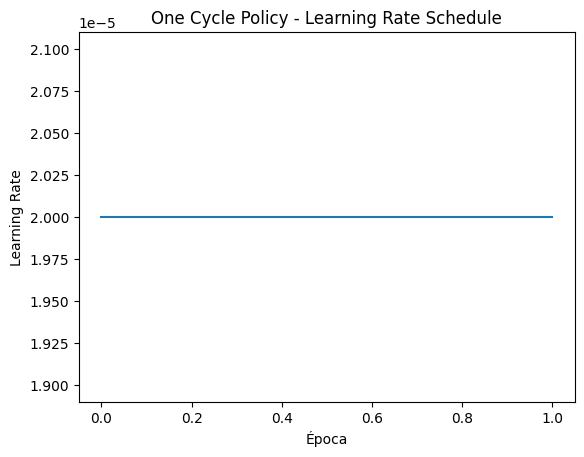

In [25]:
import matplotlib.pyplot as plt  # Corrección en la importación
lrs = [one_cycle_scheduler(epoch, initial_learning_rate) for epoch in range(epochs)]
plt.plot(range(epochs), lrs)
plt.xlabel("Época")
plt.ylabel("Learning Rate")
plt.title("One Cycle Policy - Learning Rate Schedule")
plt.show()

In [26]:
train_results = model_1.evaluate(train_dataset, verbose=1)

2025-04-17 01:56:35.437481: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 33 of 516
2025-04-17 01:56:45.053243: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 70 of 516


Advertencia: ../data/train/Shoplifting042_x264.mp4 tiene menos frames que los requeridos. Usando todo el video.


2025-04-17 01:56:55.265287: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 102 of 516
2025-04-17 01:57:05.060624: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 134 of 516
2025-04-17 01:57:14.950109: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 159 of 516
2025-04-17 01:57:25.178234: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 190 of 516
2025-04-17 01:57:35.445984: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 219 of 516
2025-04-17 01:57:45.379858: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 247 of 516
2025-04-17 01:57:55.532630: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer 

65/65 [==============================] - 179s 118ms/step - loss: 0.5142 - accuracy: 0.7248 - auc: 0.8232


In [27]:
# Evaluar en el conjunto de validación
val_results = model_1.evaluate(val_dataset, verbose=1)

9/9 [==============================] - 19s 2s/step - loss: 0.5750 - accuracy: 0.7692 - auc: 0.7805


In [28]:
# Evaluar en el conjunto de prueba
test_results = model_1.evaluate(test_dataset, verbose=1)

9/9 [==============================] - 21s 2s/step - loss: 0.6624 - accuracy: 0.6615 - auc: 0.6925


In [29]:
print("\nResultados Finales:")
print(f"Train - Loss: {train_results[0]}, Accuracy: {train_results[1]}")
print(f"Val - Loss: {val_results[0]}, Accuracy: {val_results[1]}")
print(f"Test - Loss: {test_results[0]}, Accuracy: {test_results[1]}")


Resultados Finales:
Train - Loss: 0.5142073631286621, Accuracy: 0.7248061895370483
Val - Loss: 0.5749655365943909, Accuracy: 0.7692307829856873
Test - Loss: 0.6623538136482239, Accuracy: 0.6615384817123413


### Gráfica Epochs vs Loss

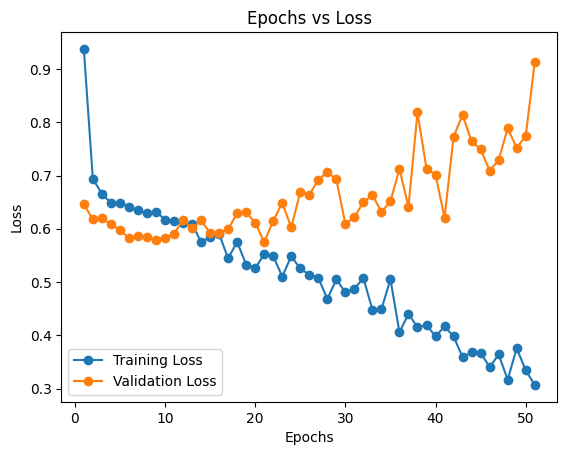

In [30]:
import matplotlib.pyplot as plt
# Extraer la pérdida de entrenamiento y validación
loss = history_full['loss']
val_loss = history_full['val_loss']

# Crear la gráfica
plt.plot(range(1, len(loss) + 1), loss, label='Training Loss', marker='o')
plt.plot(range(1, len(val_loss) + 1), val_loss, label='Validation Loss', marker='o')

# Etiquetas y título
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Epochs vs Loss')
plt.legend()
plt.grid(False)
plt.show()

### Visualización del Modelo con TSNE

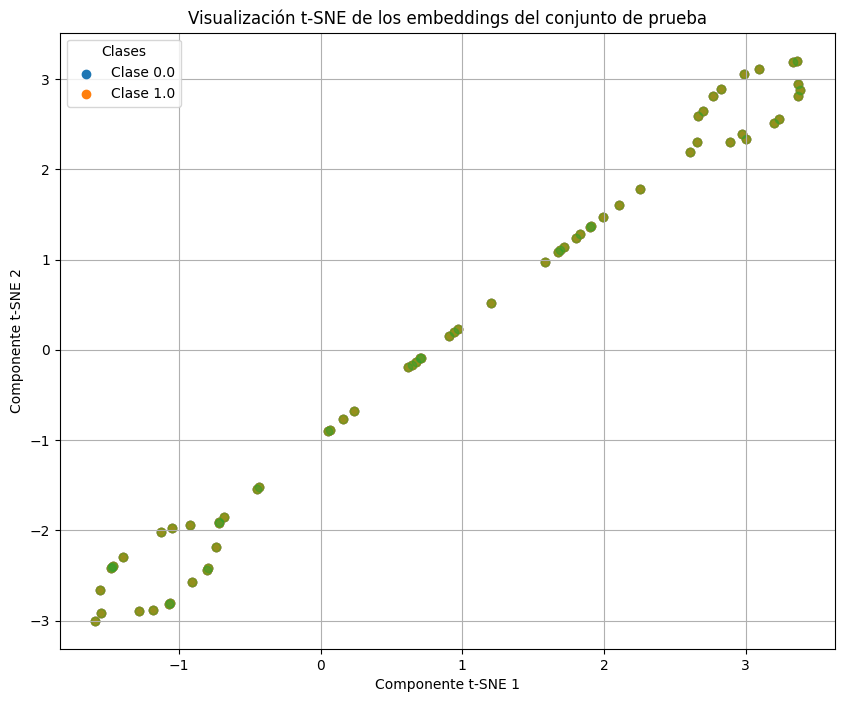

In [34]:
from sklearn.manifold import TSNE

# Obtener las representaciones del modelo
x_test = model_1.predict(test_dataset)  # Extrae los embeddings
y_test = np.concatenate([y for _, y in test_dataset])  # Obtener etiquetas reales

# Verificar el número de muestras
num_samples = x_test.shape[0]

# Aplicar t-SNE con un perplexity válido
tsne = TSNE(n_components=2, random_state=42)
x_test_tsne = tsne.fit_transform(x_test)

# Visualización
plt.figure(figsize=(10, 8))
for i in np.unique(y_test):
    idx = np.where(y_test == i)[0]
    plt.scatter(x_test_tsne[idx, 0], x_test_tsne[idx, 1], label=f"Clase {i}")

plt.title("Visualización t-SNE de los embeddings del conjunto de prueba")
plt.xlabel("Componente t-SNE 1")
plt.ylabel("Componente t-SNE 2")
plt.legend(title="Clases")
plt.grid(True)
plt.scatter(x_test_tsne[:, 0], x_test_tsne[:, 1], alpha=0.5)
plt.show()

## I3D + ConvLSTM2D

In [12]:
# Crear el DataModule
data_module = VideoDataModule(train_df, valid_df, test_df, batch_size=8)
# Obtener los datasets
train_dataset = data_module.train_dataset()
val_dataset = data_module.val_dataset()
test_dataset = data_module.test_dataset()

2025-04-18 21:31:12.565357: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-04-18 21:31:12.573755: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:ae:00.0 name: NVIDIA A100 80GB PCIe computeCapability: 8.0
coreClock: 1.41GHz coreCount: 108 deviceMemorySize: 79.25GiB deviceMemoryBandwidth: 1.76TiB/s
2025-04-18 21:31:12.575646: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1871] Adding visible gpu devices: 1
2025-04-18 21:31:12.576033: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2025-04-18 21:31:13.490844: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1258] Device interconnec

### Elección de hiperparametros

In [ ]:
from kerastuner.tuners import RandomSearch
from tensorflow.keras import Model
from tensorflow.keras.layers import (ConvLSTM2D, Dense, GlobalAveragePooling2D,
                                     Dropout, BatchNormalization)
from tensorflow.keras.metrics import AUC
import tensorflow as tf

# Supón que ya tienes importado InceptionI3d

def build_model(hp):
    class Tuned_I3D_ConvLSTM(Model):
        def __init__(self, num_classes):
            super().__init__()
            self.i3d = InceptionI3d(num_classes=num_classes, is_training=True, final_endpoint="Mixed_5c")

            # Convertimos las opciones de kernel_size en strings y las evaluamos después
            kernel_size_choice = hp.Choice('kernel_size', ['3x3', '5x5'])
            if kernel_size_choice == '3x3':
                kernel_size = (3, 3)
            else:
                kernel_size = (5, 5)

            self.conv_lstm = ConvLSTM2D(
                filters=hp.Choice('filters', [32, 64, 128]),
                kernel_size=kernel_size,
                padding='same',
                return_sequences=False,
                dropout=hp.Choice('dropout', [0.2, 0.3, 0.5]),
                recurrent_dropout=hp.Choice('recurrent_dropout', [0.2, 0.3, 0.5]),
                activation='tanh'
            )

            self.batch_norm = BatchNormalization()
            self.dense = Dense(hp.Choice('dense_units', [64, 128, 256]), activation='relu')
            self.dropout = Dropout(hp.Choice('dense_dropout', [0.2, 0.3, 0.5]))
            self.fc = Dense(num_classes, activation='sigmoid')

        def call(self, inputs, training=False):
            features, _ = self.i3d(inputs)
            x = self.conv_lstm(features)
            x = self.batch_norm(x, training=training)
            x = GlobalAveragePooling2D()(x)
            x = self.dense(x)
            x = self.dropout(x, training=training)
            return self.fc(x)

    num_classes = 2  # Cambia esto según tu caso
    model = Tuned_I3D_ConvLSTM(num_classes=num_classes)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', AUC(name='auc')])
    return model


In [15]:
from kerastuner.tuners import RandomSearch

tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=10,
    executions_per_trial=1,
    directory='tuner_logs',
    project_name='i3d_convlstm_tuning'
)

# Muestra resumen de los hiperparámetros buscados
tuner.search_space_summary()

Search space summary
Default search space size: 6
kernel_size (Choice)
{'default': '3x3', 'conditions': [], 'values': ['3x3', '5x5'], 'ordered': False}
filters (Choice)
{'default': 32, 'conditions': [], 'values': [32, 64, 128], 'ordered': True}
dropout (Choice)
{'default': 0.2, 'conditions': [], 'values': [0.2, 0.3, 0.5], 'ordered': True}
recurrent_dropout (Choice)
{'default': 0.2, 'conditions': [], 'values': [0.2, 0.3, 0.5], 'ordered': True}
dense_units (Choice)
{'default': 64, 'conditions': [], 'values': [64, 128, 256], 'ordered': True}
dense_dropout (Choice)
{'default': 0.2, 'conditions': [], 'values': [0.2, 0.3, 0.5], 'ordered': True}


In [16]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=3)

tuner.search(train_dataset, 
             epochs=10, 
             validation_data=val_dataset, 
             callbacks=[early_stopping], 
             verbose=1)

Trial 10 Complete [00h 37m 34s]
val_accuracy: 0.692307710647583

Best val_accuracy So Far: 0.800000011920929
Total elapsed time: 04h 06m 04s
INFO:tensorflow:Oracle triggered exit


In [23]:
# Obtener los 3 mejores hiperparámetros encontrados por el tuner
best_hps = tuner.get_best_hyperparameters(num_trials=3)

# Mostrar los mejores hiperparámetros
for i, hps in enumerate(best_hps, 1):
    print(f"\nMejores hiperparámetros #{i}:")
    for param in hps.values.keys():
        print(f"  {param}: {hps.get(param)}")




Mejores hiperparámetros #1:
  kernel_size: 3x3
  filters: 128
  dropout: 0.2
  recurrent_dropout: 0.3
  dense_units: 64
  dense_dropout: 0.5

Mejores hiperparámetros #2:
  kernel_size: 3x3
  filters: 32
  dropout: 0.2
  recurrent_dropout: 0.3
  dense_units: 256
  dense_dropout: 0.2

Mejores hiperparámetros #3:
  kernel_size: 5x5
  filters: 128
  dropout: 0.3
  recurrent_dropout: 0.2
  dense_units: 64
  dense_dropout: 0.3


### Modelo

In [13]:
from tensorflow.keras.layers import (ConvLSTM2D, TimeDistributed, Dense, 
                                    Flatten, GlobalAveragePooling2D, 
                                    Dropout, BatchNormalization)
from tensorflow.keras import Model

class I3D_ConvLSTM(Model):
    def __init__(self, num_classes, endpoint="Mixed_5c"):
        super(I3D_ConvLSTM, self).__init__()
        np.random.seed(42)
        tf.random.set_seed(42)
        
        # 1. Modelo base Inception I3D (congelar parcialmente)
        self.i3d = InceptionI3d(num_classes=num_classes, is_training=True, final_endpoint=endpoint)
        
        # 2. Single ConvLSTM layer simplificada
        self.conv_lstm = ConvLSTM2D(
            filters=128,  # Reducir filtros a la mitad
            kernel_size=(3, 3),
            padding='same',
            return_sequences=False,  # Solo última secuencia
            dropout=0.2,
            recurrent_dropout=0.3,
            activation='tanh'
        )
        
        # 3. Batch Normalization
        self.batch_norm = BatchNormalization()
        
        # 4. Global Average Pooling en lugar de Flatten + Dense
        self.global_pool = GlobalAveragePooling2D()
        
        # 5. Solo una capa densa intermedia
        self.dense = Dense(64, activation='relu')
        self.dropout = Dropout(0.5)
        
        # 6. Capa final
        self.fc = Dense(num_classes, activation='sigmoid')

    def call(self, inputs, training=False):
        # Extraer características con I3D
        features, _ = self.i3d(inputs)
        
        # Pasar por única capa ConvLSTM
        x = self.conv_lstm(features)
        x = self.batch_norm(x, training=training)
        
        # Pooling global
        x = self.global_pool(x)
        
        # Capa densa intermedia
        x = self.dense(x)
        x = self.dropout(x, training=training)
        
        # Salida directa
        return self.fc(x)

In [14]:
epochs = 100  # Número de épocas
initial_learning_rate = 1e-15
num_classes = 2

In [16]:
from tensorflow.keras.metrics import AUC
model_2 = I3D_ConvLSTM(num_classes=num_classes)
optimizer = tf.keras.optimizers.Adam(learning_rate=initial_learning_rate)
loss_fn = tf.keras.losses.BinaryCrossentropy(from_logits=False)
model_2.compile(optimizer=optimizer, loss=loss_fn, metrics=["accuracy", AUC(name="auc")])

In [17]:
# Instanciar el LRFinder
lr_finder = LRFinder(min_lr=initial_learning_rate, max_lr=5e-3, steps=65, smoothing=0.5)
# Ejecutar el LRFinder sobre un subconjunto del dataset (mejor si es un subconjunto pequeño)
model_2.fit(
    train_dataset.take(200),  # puedes ajustar este valor según el tamaño de tus batches
    epochs=1,
    callbacks=[lr_finder]
)


2025-04-18 21:31:37.011073: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.
2025-04-18 21:31:39.848296: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2025-04-18 21:31:39.874269: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 2100000000 Hz
2025-04-18 21:31:59.526132: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 36 of 516
2025-04-18 21:32:09.401112: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 79 of 516


Advertencia: ../data/train/Shoplifting042_x264.mp4 tiene menos frames que los requeridos. Usando todo el video.


2025-04-18 21:32:19.438430: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 116 of 516
2025-04-18 21:32:29.540945: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 145 of 516
2025-04-18 21:32:39.553581: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 175 of 516
2025-04-18 21:32:49.375893: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 208 of 516
2025-04-18 21:32:59.636489: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 238 of 516
2025-04-18 21:33:09.452178: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 270 of 516
2025-04-18 21:33:19.768797: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer 

65/65 [==============================] - 197s 293ms/step - loss: 0.7323 - accuracy: 0.5097 - auc: 0.5175


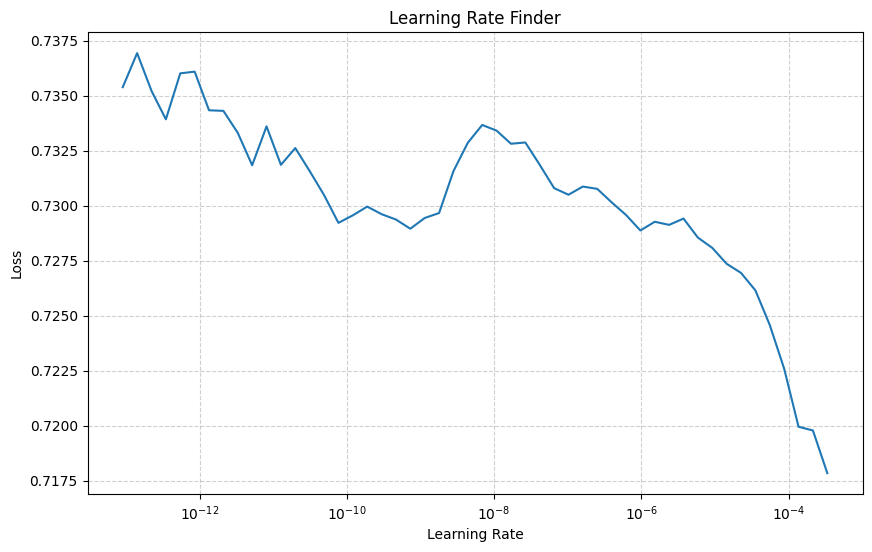

In [18]:
# Visualización
fig, ax = lr_finder.plot_loss()
plt.show()

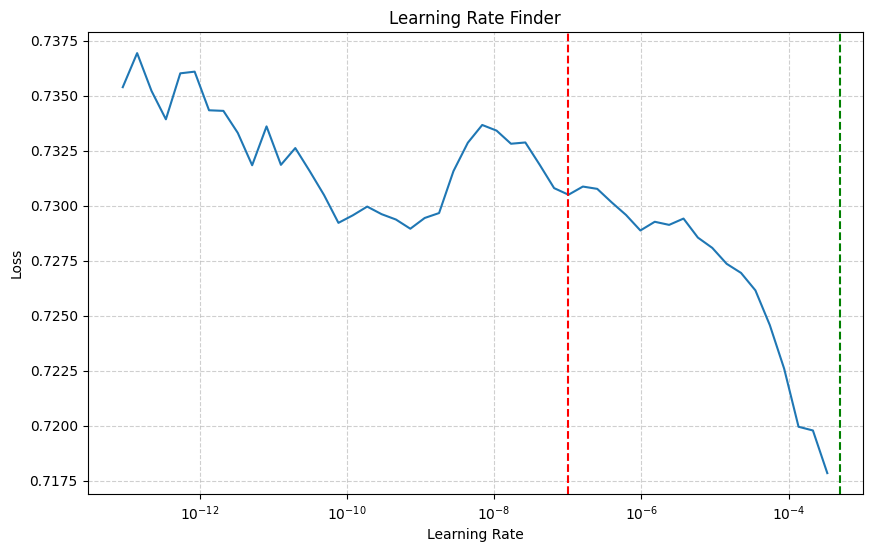

In [19]:
# Visualización
min_lr = 1e-7
max_lr = 5e-4
fig, ax = lr_finder.plot_loss()
ax.axvline(min_lr, color='r', linestyle='--', label='min_lr')
ax.axvline(max_lr, color='g', linestyle='--', label='max_lr')
plt.show()

In [20]:
def one_cycle_scheduler(epoch, lr):
    total_epochs = epochs
    warmup_epochs = total_epochs // 4

    if epoch < warmup_epochs:  # Warmup
        return initial_learning_rate + (max_lr - initial_learning_rate) * (epoch / warmup_epochs)
    
    elif epoch < total_epochs - 5:  # Cosine annealing phase
        return min_lr + (max_lr - min_lr) * 0.5 * (1 + np.cos(np.pi * (epoch - warmup_epochs) / (total_epochs - warmup_epochs - 5)))

    else:  # Final annealing phase
        return min_lr

In [21]:
history2, history_full2 = train_with_checkpoints(
    model_2,
    train_dataset,
    val_dataset,
    epochs=epochs,
    checkpoint_dir="checkpoints/i3d_convlstm_1",
    one_cycle_scheduler=one_cycle_scheduler
)

Resuming training from epoch 100
Training already completed. No new epochs to run.


In [22]:
train_results = model_2.evaluate(train_dataset, verbose=1)

2025-04-18 21:35:04.108508: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 33 of 516
2025-04-18 21:35:14.273297: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 75 of 516


Advertencia: ../data/train/Shoplifting042_x264.mp4 tiene menos frames que los requeridos. Usando todo el video.


2025-04-18 21:35:24.147842: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 109 of 516
2025-04-18 21:35:34.581423: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 141 of 516


2025-04-18 21:35:44.077559: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 167 of 516
2025-04-18 21:35:54.672511: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 201 of 516
2025-04-18 21:36:04.241880: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 228 of 516
2025-04-18 21:36:14.395843: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 261 of 516
2025-04-18 21:36:24.361303: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 293 of 516
2025-04-18 21:36:34.119677: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 325 of 516
2025-04-18 21:36:44.695887: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer 

65/65 [==============================] - 175s 125ms/step - loss: 0.2053 - accuracy: 0.9225 - auc: 0.9803


In [23]:
# Evaluar en el conjunto de validación
val_results = model_2.evaluate(val_dataset, verbose=1)

9/9 [==============================] - 21s 2s/step - loss: 0.4510 - accuracy: 0.7846 - auc: 0.8757


In [24]:
# Evaluar en el conjunto de prueba
test_results = model_2.evaluate(test_dataset, verbose=1)

      6/Unknown - 16s 3s/step - loss: 0.4716 - accuracy: 0.7500 - auc: 0.8576

9/9 [==============================] - 22s 2s/step - loss: 0.4783 - accuracy: 0.7692 - auc: 0.8561


In [25]:
print("\nResultados Finales:")
print(f"Train - Loss: {train_results[0]}, Accuracy: {train_results[1]}")
print(f"Val - Loss: {val_results[0]}, Accuracy: {val_results[1]}")
print(f"Test - Loss: {test_results[0]}, Accuracy: {test_results[1]}")


Resultados Finales:
Train - Loss: 0.20531894266605377, Accuracy: 0.9224806427955627
Val - Loss: 0.45103493332862854, Accuracy: 0.7846153974533081
Test - Loss: 0.4783419668674469, Accuracy: 0.7692307829856873


### Evolución del Learning rate

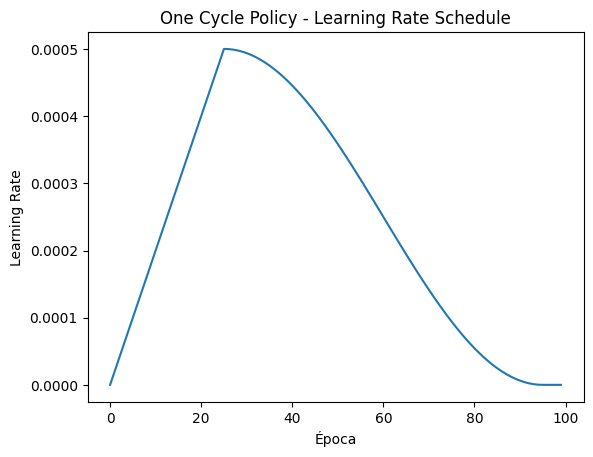

In [26]:
import matplotlib.pyplot as plt  # Corrección en la importación
lrs = [one_cycle_scheduler(epoch, initial_learning_rate) for epoch in range(epochs)]
plt.plot(range(epochs), lrs)
plt.xlabel("Época")
plt.ylabel("Learning Rate")
plt.title("One Cycle Policy - Learning Rate Schedule")
plt.show()

In [31]:
history_full2

{'loss': [0.7759543061256409,
  0.6829464435577393,
  0.6676706671714783,
  0.6426355838775635,
  0.6003555655479431,
  0.6234942674636841,
  0.6160920858383179,
  0.5973957180976868,
  0.6059794425964355,
  0.5739586353302002,
  0.5872827768325806,
  0.585599958896637,
  0.5689687728881836,
  0.5823333859443665,
  0.5877504348754883,
  0.609075129032135,
  0.543986976146698,
  0.5871516466140747,
  0.586677610874176,
  0.5492867231369019,
  0.5512195825576782,
  0.5651384592056274,
  0.5312637686729431,
  0.5736837983131409,
  0.561282753944397,
  0.5828056335449219,
  0.5293635725975037,
  0.555643618106842,
  0.5185749530792236,
  0.547344446182251,
  0.528850793838501,
  0.5632091760635376,
  0.503468930721283,
  0.4852345883846283,
  0.5123839974403381,
  0.47643131017684937,
  0.49872347712516785,
  0.4875730276107788,
  0.47526678442955017,
  0.4866892695426941,
  0.40145036578178406,
  0.4737790524959564,
  0.43429017066955566,
  0.4192650318145752,
  0.4427145719528198,
  0.41

### Gráfica Epochs vs Loss

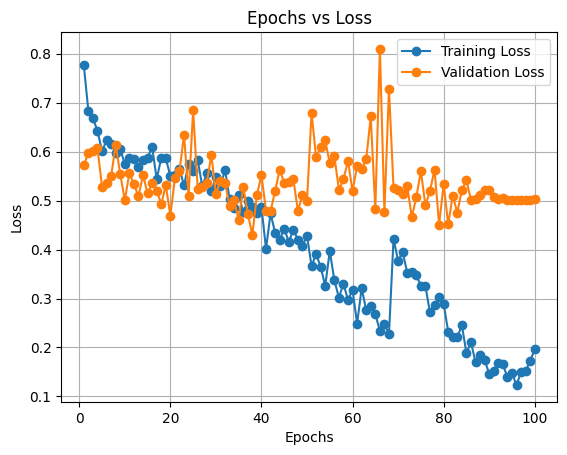

In [32]:
import matplotlib.pyplot as plt

# Extraer la pérdida de entrenamiento y validación
loss = history_full2['loss']
val_loss = history_full2['val_loss']

# Crear la gráfica
plt.plot(range(1, len(loss) + 1), loss, label='Training Loss', marker='o')
plt.plot(range(1, len(val_loss) + 1), val_loss, label='Validation Loss', marker='o')

# Etiquetas y título
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Epochs vs Loss')
plt.legend()
plt.grid(True)
plt.show()

### Visualización del Modelo con TSNE

Num samples: 65, Usando perplexity=10


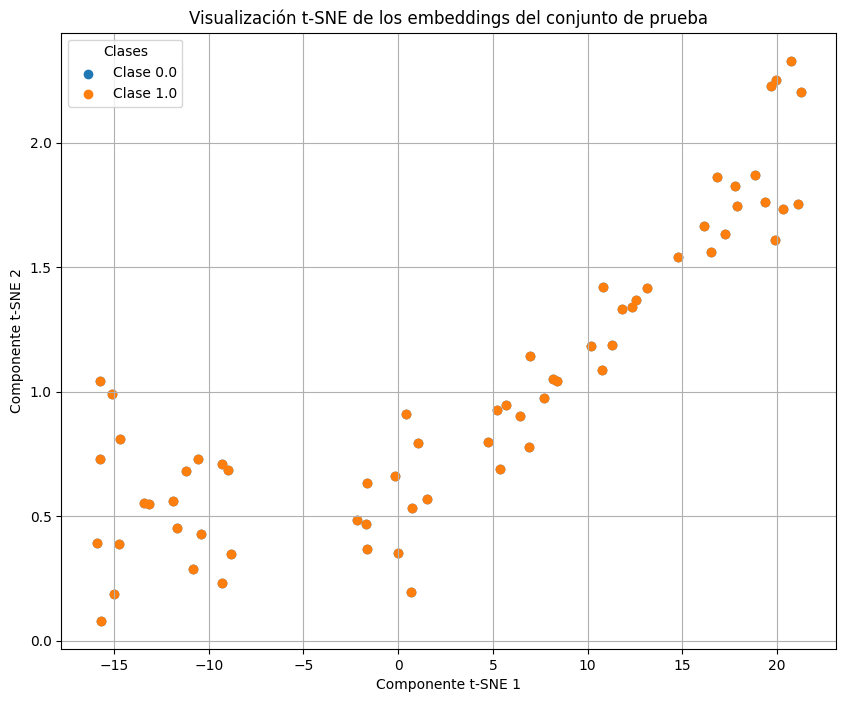

In [33]:
from sklearn.manifold import TSNE

# Obtener las representaciones del modelo
x_test = model_2.predict(test_dataset)  # Extrae los embeddings
y_test = np.concatenate([y for _, y in test_dataset])  # Obtener etiquetas reales

# Verificar el número de muestras
num_samples = x_test.shape[0]
perplexity_value = min(10, num_samples - 1)  # Ajustar perplexity dinámicamente

print(f"Num samples: {num_samples}, Usando perplexity={perplexity_value}")

# Aplicar t-SNE con un perplexity válido
tsne = TSNE(n_components=2, random_state=42, perplexity=perplexity_value)
x_test_tsne = tsne.fit_transform(x_test)

# Visualización
plt.figure(figsize=(10, 8))
for i in np.unique(y_test):
    idx = np.where(y_test == i)[0]
    plt.scatter(x_test_tsne[idx, 0], x_test_tsne[idx, 1], label=f"Clase {i}")

plt.title("Visualización t-SNE de los embeddings del conjunto de prueba")
plt.xlabel("Componente t-SNE 1")
plt.ylabel("Componente t-SNE 2")
plt.legend(title="Clases")
plt.grid(True)
plt.show()

## Comparación de modelos

In [37]:
# Carga el mejor modelo de cada uno 
model_1.load_weights("checkpoints/i3d_model_1/best_model")
model_2.load_weights("checkpoints/i3d_convlstm_1/best_model")

In [38]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

def evaluar_modelo(nombre, modelo, test_dataset):
    print('---------------------------------------------')
    print(f"Modelo {nombre}")

    # Obtener probabilidades (NO hacer argmax todavía)
    y_prob = modelo.predict(test_dataset)

    # Etiquetas predichas (clase con mayor probabilidad)
    y_pred = y_prob.argmax(axis=1)

    # Etiquetas reales (probablemente one-hot)
    y_true = np.concatenate([y.numpy() for _, y in test_dataset])

    # Asegurar formato correcto para clasificación y AUC
    if y_true.ndim == 1 or y_true.shape[1] == 1:
        # Si ya están como enteros, convertir a one-hot para AUC
        num_classes = y_prob.shape[1]
        y_true_int = y_true.flatten()
        y_true_onehot = np.eye(num_classes)[y_true_int]
    else:
        y_true_onehot = y_true
        y_true_int = y_true.argmax(axis=1)

    # Reportes
    print("Classification Report:\n", classification_report(y_true_int, y_pred))
    print("Confusion Matrix:\n", confusion_matrix(y_true_int, y_pred))

    # AUC multiclase
    auc_score = roc_auc_score(y_true_onehot, y_prob, multi_class='ovr')
    print(f"AUC (One-vs-Rest): {auc_score:.4f}")

In [39]:
# Evaluar ambos modelos
evaluar_modelo("I3D", model_1, test_dataset)


---------------------------------------------
Modelo I3D
Classification Report:
               precision    recall  f1-score   support

           0       0.66      0.70      0.68        33
           1       0.67      0.62      0.65        32

    accuracy                           0.66        65
   macro avg       0.66      0.66      0.66        65
weighted avg       0.66      0.66      0.66        65

Confusion Matrix:
 [[23 10]
 [12 20]]
AUC (One-vs-Rest): 0.6875


In [40]:
evaluar_modelo("I3D+ConvLSTM", model_2, test_dataset)

---------------------------------------------
Modelo I3D+ConvLSTM
Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.73      0.76        33
           1       0.74      0.81      0.78        32

    accuracy                           0.77        65
   macro avg       0.77      0.77      0.77        65
weighted avg       0.77      0.77      0.77        65

Confusion Matrix:
 [[24  9]
 [ 6 26]]
AUC (One-vs-Rest): 0.8594
